In [ ]:
# Set the environment 1
!pip install gensim 

# Set the environment 2
!pip install tensorflow==1.0.1

In [ ]:
# Clone RNN resources 
!git clone  https://github.com/weirenorweiren/CS230.git

# Change the working directory to e-t; not to comment directly after '%cd xxx' which could cause error
%cd CS230

# Make a directory called result in the current working directory
!mkdir result

In [ ]:
import tensorflow as tf
import numpy as np
import pprint

from time import gmtime, strftime
from dataset_ad import get_data, experiment, get_char2vec
from model_ad import RNN

def sample_parameters(params):
    combination = [
            params['dim_hidden'],
            params['dim_rnn_cell'],
            params['learning_rate'],
            params['lstm_dropout'],
            params['lstm_layer'],
            params['hidden_dropout'],
            params['dim_embed_unigram'],
            params['dim_embed_bigram'],
            params['dim_embed_trigram'],

            params['dim_embed_fourgram']
    ]

    if not params['default_params']: # If not set too use default params
        combination[0] = params['dim_hidden'] = int(np.random.uniform(
                params['dim_hidden_min'],
                params['dim_hidden_max']) // 50) * 50 
        combination[1] = params['dim_rnn_cell'] = int(np.random.uniform(
                params['dim_rnn_cell_min'],
                params['dim_rnn_cell_max']) // 50) * 50
        combination[2] = params['learning_rate'] = float('{0:.5f}'.format(np.random.uniform( # We could improve with log sampling
                params['learning_rate_min'],
                params['learning_rate_max'])))
        combination[3] = params['lstm_dropout'] = float('{0:.5f}'.format(np.random.uniform( # 5 after the decimal point
                params['lstm_dropout_min'],
                params['lstm_dropout_max'])))
        combination[4] = params['lstm_layer'] = int(np.random.uniform(
                params['lstm_layer_min'],
                params['lstm_layer_max']))
        combination[5] = params['hidden_dropout'] = float('{0:.5f}'.format(np.random.uniform(
                params['hidden_dropout_min'],
                params['hidden_dropout_max'])))
        combination[6] = params['dim_embed_unigram'] = int(np.random.uniform(
                params['dim_embed_unigram_min'],
                params['dim_embed_unigram_max']) // 10) * 10
        combination[7] = params['dim_embed_bigram'] = int(np.random.uniform(
                params['dim_embed_bigram_min'],
                params['dim_embed_bigram_max']) // 10) * 10
        combination[8] = params['dim_embed_trigram'] = int(np.random.uniform(
                params['dim_embed_trigram_min'],
                params['dim_embed_trigram_max']) // 10) * 10

        combination[9] = params['dim_embed_fourgram'] = int(np.random.uniform(
                params['dim_embed_fourgram_min'],
                params['dim_embed_fourgram_max']) // 10) * 10

    return params, combination

# !!! Always to update the parameters here !!!
saved_params = { # Manually input the flags above so that we could interact with the variables below
    'train_epoch' : 3000,
    "dim_unigram" : 71,
    "dim_bigram" : 1055,
    "dim_trigram" : 11327,
    "dim_fourgram" : 80874,
    "dim_output" : 18,
    "max_time_step" : 50,
    "min_grad" : -5,
    "max_grad" : 5,

    "batch_size" : 1024, # Important; Origin is 1000; the bigger the better

    "ngram" : 4,   
    "decay_rate" : 0.99,
    "decay_step" : 100,
    "valid_iteration" : 250,
    "dim_rnn_cell" : 200,
    "dim_rnn_cell_min" : 200,
    "dim_rnn_cell_max" : 399,
    "dim_hidden" : 200,
    "dim_hidden_min" : 200,
    "dim_hidden_max" : 399,
    "dim_embed_unigram" : 30,
    "dim_embed_unigram_min" : 10,
    "dim_embed_unigram_max" : 100,
    "dim_embed_bigram" : 100,
    "dim_embed_bigram_min" : 30,
    "dim_embed_bigram_max" : 200,
    "dim_embed_trigram" : 130,
    "dim_embed_trigram_min" : 30,
    "dim_embed_trigram_max" : 320,
    "dim_embed_fourgram" : 200, # 200/150/100, 125 is good for RNN data! 
    "dim_embed_fourgram_min" : 30,
    "dim_embed_fourgram_max" : 320,
    "lstm_layer" : 1,
    "lstm_layer_min" : 1,
    "lstm_layer_max" : 1,
    "lstm_dropout" : 0.5,
    "lstm_dropout_min" : 0.3,
    "lstm_dropout_max" : 0.8,
    "hidden_dropout" : 0.5,
    "hidden_dropout_min" : 0.3,
    "hidden_dropout_max" : 0.8,

    "learning_rate" : 0.002, # Important
    
    "learning_rate_min" : 5e-3,
    "learning_rate_max" : 5e-2,
    "default_params" : True,
    "ensemble" : True,
    "embed" : True,

    "embed_trainable" : False, # Turn to True if nothing changes when changing the learning rate
    
    "ethnicity" : False,
    "is_train" : True,
    "is_valid" : True,

    "continue_train" : False,
    "save" : True,
    
    "model_name" : "default",
    "checkpoint_dir" : "./checkpoint/",
    "data_dir" : "./data/own",
    "valid_result_path" : "/content/CS230/result/validation.txt",
    "pred_result_path" : "/content/CS230/result/pred.txt",
    "detail_result_path" : "/content/CS230/result/detail.txt"
}

In [ ]:
if saved_params['ensemble']: # uni + bi + tri +four
    model_name = 'ensemble'
elif saved_params['ngram'] == 1:
    model_name = 'unigram'
elif saved_params['ngram'] == 2:
    model_name = 'bigram'
elif saved_params['ngram'] == 3:
    model_name = 'trigram'
elif saved_params['ngram'] == 4:
    model_name = 'fourgram'
else:
    assert False, 'Not supported ngram %d'% saved_params['ngram'] # ** Origin value is True
model_name += '_embedding' if saved_params['embed'] else '_no_embedding' 
saved_params['model_name'] = '%s' % model_name
saved_params['checkpoint_dir'] += model_name
pprint.PrettyPrinter().pprint(saved_params)
saved_dataset = get_data(saved_params) # Input the passing parameters; Return train_set, valid_set, test_set, dictionary == [idx2unigram, unigram2idx, idx2country, country2ethnicity, idx2bigram, idx2trigram]

validation_writer = open(saved_params['valid_result_path'], 'a') # Open a file and add from the last ending; write in a new file if not existing
validation_writer.write(model_name + "\n")
validation_writer.write("[dim_hidden, dim_rnn_cell, learning_rate, lstm_dropout, lstm_layer, hidden_dropout, dim_embed]\n")
validation_writer.write("combination\ttop1\ttop5\tepoch\n") # \t => tab

In [ ]:
# Run the model
for _ in range(saved_params['valid_iteration']): # ??? != valid_epoch
    # Sample parameter sets
    params, combination = sample_parameters(saved_params.copy()) # If not default parameters, then update with initialization; return input dictionary and a combination LIST
    dataset = saved_dataset[:] # Copy the content into dataset; if not, we would link the two variable that can be a problem
    
    # Initialize embeddings
    uni_init = get_char2vec(dataset[0][0][:], params['dim_embed_unigram'], dataset[3][0]) # Return initializer
    bi_init = get_char2vec(dataset[0][1][:], params['dim_embed_bigram'], dataset[3][4]) # The first [] is the outermost dimension == train_set or dictionary; [3][i] gives the outermost dimension in dictionary
    tri_init = get_char2vec(dataset[0][2][:], params['dim_embed_trigram'], dataset[3][5]) # Easy to understand with get_data()
    four_init = get_char2vec(dataset[0][3][:], params['dim_embed_fourgram'], dataset[3][6])
    
    print(model_name, 'Parameter sets: ', end='')
    pprint.PrettyPrinter().pprint(combination)
    
    rnn_model = RNN(params, [uni_init, bi_init, tri_init, four_init])
    top1, top5, ep = experiment(rnn_model, dataset, params) # With train_iterations; return max_top1, max_top5, max_top1_epoch
    
    validation_writer.write(str(combination) + '\t')
    validation_writer.write(str(top1) + '\t' + str(top5) + '\tEp:' + str(ep) + '\n')

validation_writer.close()

ensemble_embedding Parameter sets: [200, 200, 0.002, 0.5, 1, 0.5, 30, 100, 130, 200]
## Building an RNN model
Tensor("Unigram/Unigram/embedding_lookup:0", shape=(?, 50, 30), dtype=float32)
Tensor("Bigram/Bigram/embedding_lookup:0", shape=(?, 50, 100), dtype=float32)
Tensor("Trigram/Trigram/embedding_lookup:0", shape=(?, 50, 130), dtype=float32)
Tensor("Fourgram/Fourgram/embedding_lookup:0", shape=(?, 50, 200), dtype=float32)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


model variables ['Unigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/weights:0', 'Unigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/biases:0', 'Unigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/basic_lstm_cell/weights:0', 'Unigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/basic_lstm_cell/biases:0', 'Unigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/attention/attn_w:0', 'Unigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/attention/attn_v:0', 'Unigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/attention/weights:0', 'Unigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/attention/biases:0', 'Unigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/attn_output_projection/weights:0', 'Unigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/attn_output_projection/biases:0', 'Bigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/weights:0', 'Bigram/RNN/multi_rnn_cell/cell_0/attention_cell_wrapper/biases:0', 'Bigram/RNN/multi_rnn_cell/cell_0/

In [ ]:
dataset = saved_dataset[:]
train_set = dataset[0]
valid_set = dataset[1]
test_set = dataset[2]
[idx2unigram, unigram2idx, idx2country, country2ethnicity, idx2bigram, idx2trigram, idx2fourgram] = dataset[3]

In [ ]:
# Test
# print(len(train_set[3][:])) # The length of length_set == #names; Why is it the same as len(train_set[:][3]])??? Because train_set[:] == train_set
# len(train_set[:]) # The length of LIST train_set = 5
# len(train_set) # Also, the length of LIST train_set = 5

# np.shape(test_set[1][0])
# test_set[1][200]
# len(dataset[3][5])
# idx2unigram[0]
# np.shape(train_set[2][101])
# idx2bigram
# train_set[2][100]

country2ethnicity

{}

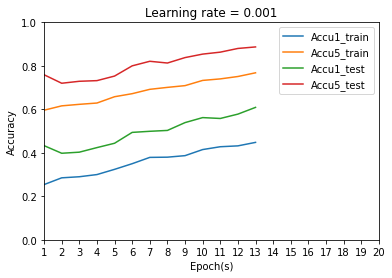

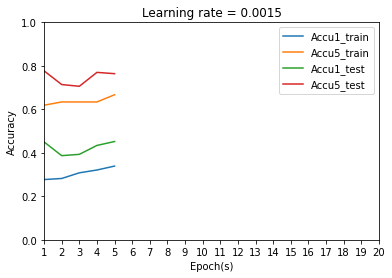

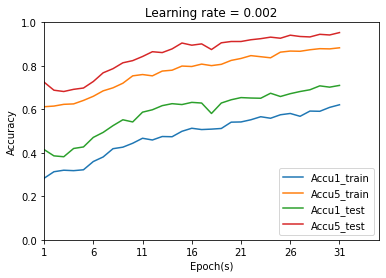

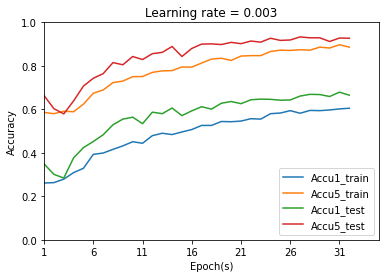

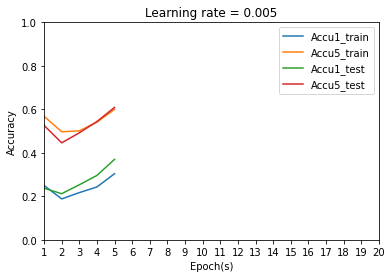

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# attn_length = 5, batch size = 1024
accu1_1_tr = [0.178, 0.254, 0.285, 0.290, 0.300, 0.324, 0.350, 0.379, 0.380, 0.387, 0.415, 0.428, 0.432, 0.448]
accu5_1_tr = [0.501, 0.596, 0.616, 0.623, 0.629, 0.658, 0.672, 0.692, 0.701, 0.709, 0.733, 0.740, 0.751, 0.768]
accu1_1_te = [0.415, 0.433, 0.398, 0.403, 0.424, 0.444, 0.494, 0.499, 0.503, 0.539, 0.562, 0.558, 0.578, 0.609]
accu5_1_te = [0.756, 0.759, 0.720, 0.729, 0.732, 0.753, 0.800, 0.821, 0.813, 0.838, 0.854, 0.863, 0.880, 0.887]

accu1_15_tr = [0.196, 0.277, 0.282, 0.308, 0.321, 0.339]
accu5_15_tr = [0.523, 0.619, 0.634, 0.634, 0.634, 0.667]
accu1_15_te = [0.456, 0.450, 0.387, 0.393, 0.434, 0.452]
accu5_15_te = [0.804, 0.777, 0.714, 0.706, 0.770, 0.764]

accu1_2_tr = [0.195, 0.283, 0.313, 0.320, 0.318, 0.322, 0.360, 0.381, 0.419, 0.426, 0.444, 0.467, 0.459, 0.475, 0.474, 0.499, 0.513, 0.507, 0.509, 0.512, 0.541, 0.542, 0.552, 0.566, 0.559, 0.575, 0.581, 0.568, 0.592, 0.591, 0.609, 0.621]
accu5_2_tr = [0.498, 0.612, 0.615, 0.623, 0.625, 0.641, 0.660, 0.685, 0.699, 0.720, 0.754, 0.760, 0.754, 0.776, 0.780, 0.799, 0.797, 0.808, 0.801, 0.807, 0.825, 0.834, 0.847, 0.842, 0.837, 0.863, 0.868, 0.867, 0.874, 0.879, 0.878, 0.883]
accu1_2_te = [0.422, 0.415, 0.386, 0.382, 0.420, 0.427, 0.471, 0.494, 0.525, 0.552, 0.542, 0.587, 0.598, 0.617, 0.626, 0.622, 0.632, 0.629, 0.581, 0.629, 0.644, 0.654, 0.652, 0.651, 0.674, 0.659, 0.672, 0.682, 0.690, 0.708, 0.702, 0.710]
accu5_2_te = [0.741, 0.725, 0.688, 0.682, 0.692, 0.698, 0.728, 0.768, 0.787, 0.814, 0.824, 0.843, 0.865, 0.861, 0.878, 0.905, 0.895, 0.901, 0.875, 0.906, 0.912, 0.912, 0.920, 0.925, 0.932, 0.927, 0.941, 0.935, 0.933, 0.945, 0.942, 0.953]

accu1_3_tr = [0.199, 0.261, 0.263, 0.279, 0.309, 0.329, 0.393, 0.399, 0.416, 0.432, 0.451, 0.444, 0.479, 0.490, 0.484, 0.496, 0.507, 0.526, 0.526, 0.544, 0.543, 0.546, 0.557, 0.555, 0.580, 0.583, 0.594, 0.582, 0.595, 0.594, 0.597, 0.602, 0.605]
accu5_3_tr = [0.511, 0.586, 0.580, 0.591, 0.589, 0.624, 0.674, 0.689, 0.723, 0.730, 0.750, 0.751, 0.770, 0.777, 0.778, 0.795, 0.794, 0.813, 0.831, 0.835, 0.825, 0.845, 0.847, 0.847, 0.866, 0.872, 0.871, 0.874, 0.872, 0.886, 0.882, 0.897, 0.886]
accu1_3_te = [0.421, 0.349, 0.301, 0.284, 0.377, 0.424, 0.452, 0.483, 0.529, 0.555, 0.564, 0.534, 0.587, 0.580, 0.606, 0.571, 0.593, 0.612, 0.601, 0.628, 0.636, 0.626, 0.644, 0.647, 0.646, 0.642, 0.643, 0.661, 0.669, 0.668, 0.659, 0.679, 0.665]
accu5_3_te = [0.748, 0.663, 0.603, 0.579, 0.639, 0.707, 0.743, 0.764, 0.815, 0.805, 0.843, 0.829, 0.856, 0.862, 0.889, 0.843, 0.880, 0.900, 0.901, 0.898, 0.908, 0.902, 0.914, 0.909, 0.927, 0.917, 0.919, 0.933, 0.929, 0.929, 0.912, 0.928, 0.927]

accu1_5_tr = [0.184, 0.250, 0.188, 0.217, 0.243, 0.304]
accu5_5_tr = [0.522, 0.568, 0.497, 0.501, 0.541, 0.600]
accu1_5_te = [0.416, 0.237, 0.212, 0.253, 0.296, 0.370]
accu5_5_te = [0.744, 0.526, 0.446, 0.492, 0.544, 0.609]

plt.plot(accu1_1_tr);
plt.plot(accu5_1_tr);
plt.plot(accu1_1_te);
plt.plot(accu5_1_te);
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')
plt.title('Learning rate = 0.001')
plt.legend(['Accu1_train', 'Accu5_train', 'Accu1_test', 'Accu5_test'])
plt.axis([1,20,0,1])
plt.xticks(np.arange(1,21,1));

plt.figure()
plt.plot(accu1_15_tr);
plt.plot(accu5_15_tr);
plt.plot(accu1_15_te);
plt.plot(accu5_15_te);
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')
plt.title('Learning rate = 0.0015')
plt.legend(['Accu1_train', 'Accu5_train', 'Accu1_test', 'Accu5_test'])
plt.axis([1,20,0,1])
plt.xticks(np.arange(1,21,1));

plt.figure()
plt.plot(accu1_2_tr);
plt.plot(accu5_2_tr);
plt.plot(accu1_2_te);
plt.plot(accu5_2_te);
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')
plt.title('Learning rate = 0.002')
plt.legend(['Accu1_train', 'Accu5_train', 'Accu1_test', 'Accu5_test'])
plt.axis([1,35,0,1])
plt.xticks(np.arange(1,36,5));

plt.figure()
plt.plot(accu1_3_tr);
plt.plot(accu5_3_tr);
plt.plot(accu1_3_te);
plt.plot(accu5_3_te);
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')
plt.title('Learning rate = 0.003')
plt.legend(['Accu1_train', 'Accu5_train', 'Accu1_test', 'Accu5_test'])
plt.axis([1,35,0,1])
plt.xticks(np.arange(1,36,5));

plt.figure()
plt.plot(accu1_5_tr);
plt.plot(accu5_5_tr);
plt.plot(accu1_5_te);
plt.plot(accu5_5_te);
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')
plt.title('Learning rate = 0.005')
plt.legend(['Accu1_train', 'Accu5_train', 'Accu1_test', 'Accu5_test'])
plt.axis([1,20,0,1])
plt.xticks(np.arange(1,21,1));

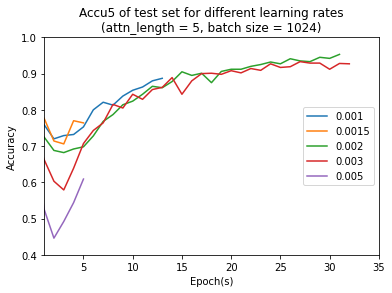

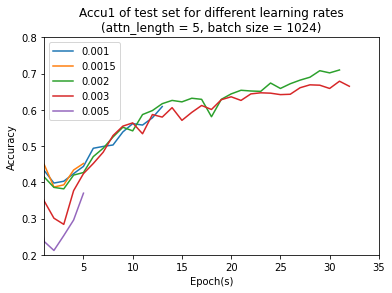

In [2]:
plt.plot(accu5_1_te);
plt.plot(accu5_15_te);
plt.plot(accu5_2_te);
plt.plot(accu5_3_te);
plt.plot(accu5_5_te);
plt.xlabel('Epoch(s)');
plt.ylabel('Accuracy');
plt.title('Accu5 of test set for different learning rates\n(attn_length = 5, batch size = 1024)');
plt.legend(['0.001', '0.0015', '0.002', '0.003', '0.005'], loc='right');
plt.axis([1,35,0.4,1]);
# plt.xticks(np.arange(1,36,5));
plt.savefig('accu5.jpg')

plt.figure()
plt.plot(accu1_1_te);
plt.plot(accu1_15_te);
plt.plot(accu1_2_te);
plt.plot(accu1_3_te);
plt.plot(accu1_5_te);
plt.xlabel('Epoch(s)');
plt.ylabel('Accuracy');
plt.title('Accu1 of test set for different learning rates\n(attn_length = 5, batch size = 1024)');
plt.legend(['0.001', '0.0015', '0.002', '0.003', '0.005']);
plt.axis([1,35,0.2,0.8]);
# plt.xticks(np.arange(1,36,5));
plt.savefig('accu1.jpg')